# Symbol-level simulation
Let's first consider a simple symbol-level simulation. We consider a single-input
multiple-output (SIMO) system. First, we generate the transmit symbols
$$\mathbf{x}$$ based on i.i.d complex Gaussian distribution with zero mean and variance 1.
Then, we consider a single path channel $\mathbf{w}$ with i.i.d uniform phase in
$[0,2\pi]$. For the receiver, we consider $n_\mathrm{rx}=16$ receive antennas.
For each design option $\theta$ we create a different radio-frequency front-end (RFFE),
that can be described by a unique non-linear function $\Phi_\theta$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

in_df = pd.read_csv(r'../datasets/rx_1/idata_1.csv')
p0_df = pd.read_csv(r'../datasets/rx_1/param_0_1_1.csv')
p1_df = pd.read_csv(r'../datasets/rx_1/param_1_1_1.csv')

In [2]:
fc = float(p0_df['fc'])
fs = float(p0_df['fs'])
nit = int(p0_df['nit'])
nrx = int(p0_df['nrx'])
nsnr = int(p0_df['nsnr'])
nx = int(p0_df['nx'])
ndsgn = 4;

In [3]:
# Random tx data
x = np.char.replace(np.array(in_df['x'],dtype=str),'i','j').astype(np.complex)

# Channel w
tmp = []
for i in range(1,nrx+1):
  tmp.append(np.char.replace(np.array(in_df['w_'+str(i)],dtype=str),'i','j').astype(np.complex))

w = np.empty([nx, nrx], dtype=complex)
for irx in range(nrx):
  w[:,irx] = tmp[irx]

# Received data with no noise
tmp = []
for i in range(1,nrx+1):
  tmp.append(np.char.replace(np.array(in_df['y_'+str(i)],dtype=str),'i','j').astype(np.complex))

y = np.empty([nx, nrx], dtype=complex)
for irx in range(nrx):
  y[:,irx] = tmp[irx]


# Received data at the antenna at various rx power levels
tmp = []
for i in range(1,nsnr*nrx+1):
  tmp.append(np.char.replace(np.array(in_df['yant_'+str(i)],dtype=str),'i','j').astype(np.complex))

r = np.empty([nx, nrx, nsnr], dtype=complex)
for isnr in range(nsnr):
  for irx in range(nrx):
    r[:,irx,isnr] = tmp[isnr*nrx + irx]

In [4]:
# Output of the RFFE non-linear function Phi(r)

y_rffe = np.empty([nx, nrx, nsnr, ndsgn], dtype=complex)
x_hat = np.empty([nx, nsnr, ndsgn], dtype=complex)

for idsgn in range(ndsgn):
  out_df = pd.read_csv(r'../datasets/rx_1/odata_'+str(idsgn+1)+'_1.csv')

  tmp = []
  for i in range(1,nsnr*nrx+1):
    tmp.append(np.char.replace(np.array(out_df['yrffe_'+str(i)],dtype=str),'i','j').astype(np.complex))

  for isnr in range(nsnr):
    for irx in range(nrx):
      y_rffe[:,irx,isnr,idsgn] = tmp[isnr*nrx + irx]

  # Predicted tx data
  tmp = []
  for i in range(1,nsnr+1):
    tmp.append(np.char.replace(np.array(out_df['xhat_'+str(i)],dtype=str),'i','j').astype(np.complex))

  for isnr in range(nsnr):
      x_hat[:,isnr,idsgn] = tmp[isnr]

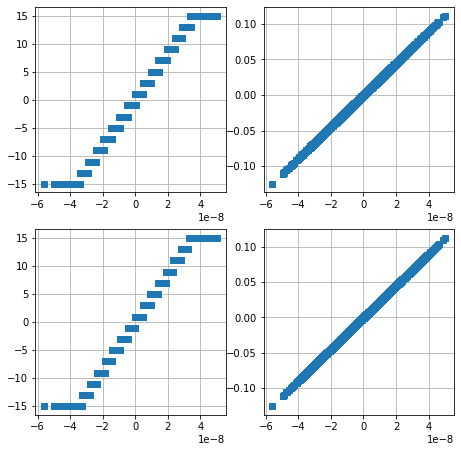

In [60]:
irx = 0
isnr = 30
plt.rcParams["figure.figsize"] = (7.5, 7.5)
for idsgn in range(ndsgn):
  plt.subplot(2,2,idsgn+1)
  plt.plot(r[:,irx,isnr].real, y_rffe[:,irx,isnr,idsgn].real, 's')
  plt.grid()

In [183]:
y_rffe.shape

(10000, 16, 31, 4)

In [184]:
isnr = 10
idsgn = 1
y_itr = np.squeeze(y_rffe[:,:,isnr,idsgn])
r_itr = r[:,:,isnr]
y_itr.shape
r_itr.shape

(10000, 16)

In [185]:
import tensorflow as tf
from tensorflow import keras

# loss_val = tf.cast(tf.keras.losses.MSE(r_itr, y_itr),tf.float32)
# print('Loss Value {}'.format(loss_val))
# print('Mean Loss {}'.format(np.mean(loss_val)))

In [201]:
class Inverter():
    def __init__(self, number_of_rx):
        self.size = number_of_rx
        self.training = True 
        # Create a `Sequential` model and add a Dense layer as the first layer.
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.Input(shape=(self.size,) , name="Phi_Input"))
        self.model.add(tf.keras.layers.Dense(self.size*2, activation='relu', name="Dense_1"))
        self.model.add(tf.keras.layers.Dense(self.size, name="R_output"))
        self.model.compile(optimizer='sgd', loss='mean_squared_error')
        print('The model summar: \n {}'.format(self.model.summary()))

    def predict(self, phi):
        return self.model.predict(phi)

    def fit(self, phi_tr, r_tr, phi_val, r_val, batch_size = 64, epochs=5,verbose=0):
        self.model.fit(phi_tr, r_tr, batch_size=batch_size,epochs=epochs,validation_data=(phi_val, r_val) ,verbose=verbose)


In [202]:
# Create class
myInv_amp = Inverter(y_itr.shape[1])
myInv_phase = Inverter(y_itr.shape[1])

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
R_output (Dense)             (None, 16)                528       
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________
The model summar: 
 None
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
R_output (Dense)             (None, 16)                528       
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________
T

In [203]:
y_itr[1:5,:]

array([[ 0.01312485+0.00591137j, -0.03260088+0.03690234j,
        -0.02972109-0.00302277j, -0.02415562-0.04115967j,
        -0.08682765-0.0243844j , -0.03269601-0.00114704j,
         0.03570674+0.05329696j, -0.02096318+0.02800357j,
        -0.04911027+0.05099002j,  0.02007129-0.02111798j,
         0.06247738-0.00480635j,  0.02761505-0.02545828j,
        -0.04079741+0.02889954j, -0.03800023+0.01587778j,
         0.03189207-0.00419298j,  0.01300263-0.00308128j],
       [-0.00456301-0.05826509j, -0.0868191 -0.00050798j,
        -0.05241824-0.00794887j,  0.00772384+0.06944084j,
         0.05267647-0.02170806j,  0.06595642+0.02329904j,
        -0.01370055-0.07467655j, -0.02169121+0.06087913j,
        -0.04287423-0.03919618j,  0.0032342 -0.04265234j,
         0.04262974-0.05713014j,  0.05639004+0.04883357j,
        -0.03365651-0.05425558j, -0.01429336-0.04584882j,
        -0.01373651+0.02118902j,  0.04241338-0.00473619j],
       [-0.00726111-0.05275457j, -0.07301712-0.01915377j,
         0.0

In [204]:
# Normalize the input phi
# Some issues with normalization we need to figure out

#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(y_itr, r_itr, test_size=0.1)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)
print('Shape of train {}'.format(X_train.shape))
print('Shape of test {}'.format(X_test.shape))
print('Shape of valid {}'.format(X_valid.shape))


# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
# from sklearn.preprocessing import StandardScaler

# input_scaler = StandardScaler()
# input_scaler.fit(np.abs(X_train))

# output_scaler = StandardScaler()
# output_scaler.fit(y_train)

# X_train = input_scaler.transform(X_train)
# X_valid = input_scaler.transform(X_valid)
# X_test = input_scaler.transform(X_test)


# y_train = output_scaler.transform(y_train)
# y_valid = output_scaler.transform(y_valid)
# y_test = output_scaler.transform(y_test)




print('Mean of the x train amp {}'.format(np.mean(X_train_amp)))
print('Mean of the y train amp {}'.format(np.mean(y_train_amp)))



# Get the amplitude and phase for models
X_train_phase = np.angle(X_train)
X_train_amp = np.abs(X_train)
y_train_phase = np.angle(y_train)
y_train_amp = np.abs(y_train)


X_test_phase = np.angle(X_test)
X_test_amp = np.abs(X_test)
y_test_phase = np.angle(y_test)
y_test_amp = np.abs(y_test)

X_valid_phase = np.angle(X_valid)
X_valid_amp = np.abs(X_valid)
y_valid_phase = np.angle(y_valid)
y_valid_amp = np.abs(y_valid)


# mean_ratio = (np.mean(X_train_amp)/np.mean(y_train_amp))
# y_train_amp *= mean_ratio
# y_test_amp *= mean_ratio
# y_valid_amp *= mean_ratio
# np.mean(y_train_amp)



Shape of train (9000, 16)
Shape of test (500, 16)
Shape of valid (500, 16)


ValueError: Complex data not supported
[[-0.0412666 +0.01238431j -0.06532157+0.05071886j  0.03542907+0.00489855j
  ...  0.04252053+0.02760351j -0.06542837+0.04102459j
   0.03519216-0.04604568j]
 [-0.02207827-0.0078266j  -0.02316407-0.03731146j -0.00715607+0.00989477j
  ...  0.04993407+0.05854175j  0.00104546-0.0132661j
   0.03671542-0.01938713j]
 [-0.03179392+0.01238533j -0.04330196+0.02218541j  0.01039555-0.02630369j
  ...  0.02536243-0.00335426j -0.01750864+0.05168657j
  -0.00135085-0.00328434j]
 ...
 [-0.0089808 -0.03446439j -0.04490885+0.02452841j  0.02040876+0.00662291j
  ...  0.0098938 +0.01210916j  0.01106963+0.03354875j
   0.00374203+0.02969456j]
 [ 0.00852569-0.01935108j  0.0840827 -0.0286016j   0.00673851+0.02525897j
  ...  0.01159253-0.04846113j  0.01631508-0.05060832j
  -0.0183179 +0.04879481j]
 [-0.0062521 -0.00419877j -0.0203071 -0.003403j   -0.0099921 +0.01836443j
  ... -0.00618264-0.01074328j -0.01193833+0.01626654j
   0.03230237-0.05724273j]]


In [194]:
# Train Model
myInv_amp.fit(X_train_amp, y_train_amp, X_valid_amp, y_valid_amp, batch_size = 32, epochs=100,verbose=1)

Epoch 1/100
282/282 [==============================] - 1s 2ms/step - loss: 1.1707 - val_loss: 0.3828
Epoch 2/100
282/282 [==============================] - 1s 2ms/step - loss: 0.3086 - val_loss: 0.2258
Epoch 3/100
282/282 [==============================] - 1s 2ms/step - loss: 0.2239 - val_loss: 0.1972
Epoch 4/100
282/282 [==============================] - 1s 2ms/step - loss: 0.2006 - val_loss: 0.1800
Epoch 5/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1839 - val_loss: 0.1682
Epoch 6/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1719 - val_loss: 0.1598
Epoch 7/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1624 - val_loss: 0.1536
Epoch 8/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1569 - val_loss: 0.1488
Epoch 9/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1513 - val_loss: 0.1446
Epoch 10/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1470 - val_lo

282/282 [==============================] - 1s 2ms/step - loss: 0.1183 - val_loss: 0.1195
Epoch 82/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1242 - val_loss: 0.1194
Epoch 83/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1194 - val_loss: 0.1188
Epoch 84/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1193 - val_loss: 0.1193
Epoch 85/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1188 - val_loss: 0.1194
Epoch 86/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1233 - val_loss: 0.1191
Epoch 87/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1178 - val_loss: 0.1189
Epoch 88/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1190 - val_loss: 0.1192
Epoch 89/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1198 - val_loss: 0.1193
Epoch 90/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1182 - val_loss: 

In [195]:
myInv_phase.fit(X_train_phase, y_train_phase, X_valid_phase, y_valid_phase, batch_size = 32, epochs=100,verbose=1)

Epoch 1/100
282/282 [==============================] - 1s 3ms/step - loss: 3.7920 - val_loss: 3.0374
Epoch 2/100
282/282 [==============================] - 1s 2ms/step - loss: 2.9541 - val_loss: 2.8024
Epoch 3/100
282/282 [==============================] - 1s 2ms/step - loss: 2.7819 - val_loss: 2.7073
Epoch 4/100
282/282 [==============================] - 1s 2ms/step - loss: 2.6849 - val_loss: 2.6633
Epoch 5/100
282/282 [==============================] - 1s 2ms/step - loss: 2.6537 - val_loss: 2.6356
Epoch 6/100
282/282 [==============================] - 1s 2ms/step - loss: 2.6183 - val_loss: 2.6203
Epoch 7/100
282/282 [==============================] - 1s 2ms/step - loss: 2.6031 - val_loss: 2.6102
Epoch 8/100
282/282 [==============================] - 1s 2ms/step - loss: 2.5814 - val_loss: 2.6001
Epoch 9/100
282/282 [==============================] - 1s 2ms/step - loss: 2.5658 - val_loss: 2.5952
Epoch 10/100
282/282 [==============================] - 1s 2ms/step - loss: 2.5695 - val_lo

282/282 [==============================] - 1s 2ms/step - loss: 2.4452 - val_loss: 2.4943
Epoch 82/100
282/282 [==============================] - 1s 2ms/step - loss: 2.4386 - val_loss: 2.4940
Epoch 83/100
282/282 [==============================] - 1s 2ms/step - loss: 2.4720 - val_loss: 2.4951
Epoch 84/100
282/282 [==============================] - 1s 2ms/step - loss: 2.4209 - val_loss: 2.4939
Epoch 85/100
282/282 [==============================] - 1s 2ms/step - loss: 2.4372 - val_loss: 2.4925
Epoch 86/100
282/282 [==============================] - 1s 2ms/step - loss: 2.4401 - val_loss: 2.4923
Epoch 87/100
282/282 [==============================] - 1s 2ms/step - loss: 2.4313 - val_loss: 2.4917
Epoch 88/100
282/282 [==============================] - 1s 2ms/step - loss: 2.4379 - val_loss: 2.4930
Epoch 89/100
282/282 [==============================] - 1s 2ms/step - loss: 2.4486 - val_loss: 2.4929
Epoch 90/100
282/282 [==============================] - 1s 2ms/step - loss: 2.4391 - val_loss: 

In [196]:
y_hat = myInv_amp.predict(X_test_amp)*np.exp(1j*myInv_phase.predict(X_test_phase))
y_hat.dtype
y_hat = myInv_amp.predict(X_test_amp)
y_hat[1:5,:]

array([[-0.47248513, -0.46469423, -0.49873307, -0.4536601 , -0.5044913 ,
        -0.46117225, -0.45426604, -0.5467412 , -0.47005236, -0.46848682,
        -0.4567556 , -0.48530337, -0.49383712, -0.45402774, -0.47693425,
        -0.45821887],
       [-0.10168248, -0.1386367 , -0.18258107, -0.29929402, -0.0430944 ,
        -0.16570908, -0.13525802, -0.19015944, -0.11099108, -0.21158667,
        -0.1814876 , -0.15483308, -0.14375627, -0.0805324 , -0.08564842,
        -0.15448338],
       [-1.2861072 , -1.2695291 , -1.3132327 , -1.2577229 , -1.3348595 ,
        -1.231543  , -1.3723589 , -1.2563733 , -1.2344033 , -1.2684028 ,
        -1.2816248 , -1.3147794 , -1.3084613 , -1.2889698 , -1.2331805 ,
        -1.3483095 ],
       [-1.208308  , -1.2203457 , -1.2028427 , -1.1810404 , -1.2240746 ,
        -1.1984922 , -1.2570475 , -1.1719648 , -1.1772426 , -1.2585676 ,
        -1.299225  , -1.209944  , -1.1810725 , -1.2127668 , -1.235289  ,
        -1.2368144 ]], dtype=float32)

In [197]:
y_test_amp[1:3,:]

array([[-0.31758064, -0.31758064, -0.31758064, -0.31758064, -0.31758064,
        -0.31758064, -0.31758064, -0.31758064, -0.31758064, -0.31758064,
        -0.31758064, -0.31758064, -0.31758064, -0.31758064, -0.31758064,
        -0.31758064],
       [-0.08387244, -0.08387244, -0.08387244, -0.08387244, -0.08387244,
        -0.08387244, -0.08387244, -0.08387244, -0.08387244, -0.08387244,
        -0.08387244, -0.08387244, -0.08387244, -0.08387244, -0.08387244,
        -0.08387244]])

In [198]:
X_test_amp[1:3,:]

array([[ 0.16233379, -0.1514521 , -0.7507202 , -0.45484341, -0.64494244,
        -0.40678551, -1.27610833,  0.85992933, -0.1536338 , -1.22413049,
         1.45589907, -0.56846614,  0.0529663 , -0.52192677, -0.13726423,
        -1.46106772],
       [-0.82792304,  0.76737084, -0.42894777,  0.42505805, -0.7649639 ,
         0.30143628,  0.29564324, -0.2335835 , -0.7662664 , -1.05038995,
        -0.44579673, -0.16322274, -0.52352843,  0.92922641,  1.29967037,
        -0.64297887]])

In [151]:
np.mean(X_test_amp)

0.03924402165465134

In [152]:
np.mean(y_test_amp)

0.039310276136743955